# CIGO Data scientist Challenge

## Motivación 

Somos un centro de Transformación Digital Interna que busca de manera innovadora mejorar los procesos del Banco adoptando prácticas ágiles

Nos encargamos de impulsar las iniciativas de los funcionarios como si fueran Emprendedores, Tomamos el concepto de incubadoras acompañándolos y empoderándolos  para que sus iniciativas sean materializadas con mínimas soluciones viables, rápidas y eficientes.

En CIGO buscamos explorar nuevas iniciativas  con Inteligencia artificial que nos permita aumentar la productividad y los espacios de trabajo de tal forma podamos tener un crecimiento exponencial en ingresos y disminución de costos administrativos, en el equipo CIGO buscamos transformar el Banco con nuevas tendencias tecnológicas y nuevas formas de trabajo.

## Consigna 

El objetivo de este desafío consiste en utilizar un conjunto de datos proporcionados

El cual consiste en textos generados tanto por Modelos de Lenguaje Largos (LLM) tales como Chatgpt, Llama2 entre otros, como por autores humanos.  El reto es doble:

### Análisis de estilo: 

Realizar el proceso de exploración y análisis sobre los textos para cada texto (EDA), logrando identificar elementos o aspectos distintivos en el estilo de texto generado por los LLMs en comparación con los creados por los humanos.

In [508]:
#libreriaa necesarias
#nltk
import nltk
nltk.download('stopwords')
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
#tensorflow-keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

#sklearn
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import matplotlib.pyplot as plt
import numpy as np
import re
import string




[nltk_data] Downloading package stopwords to /home/sergio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [509]:
#importamos los datos
data=pd.read_excel("database_clean.xlsx")
data.drop_duplicates(inplace=True)

### Clasificación de textos:

Desarrollar un modelo de aprendizaje automático capaz de realizar la clasificación de los textos según autoría es decir basándose en la columna clasificación y un modelo por cada tipo de fuente, reportando sus respectivas métricas F1, matriz de confusión o la que considere pertinente para este caso de uso. RECOMENDACIÓN: Para el último punto puede iterar el mismo modelo por cada tipo de fuente y generar los resultados y métricas.

<Axes: xlabel='Tipo de fuente'>

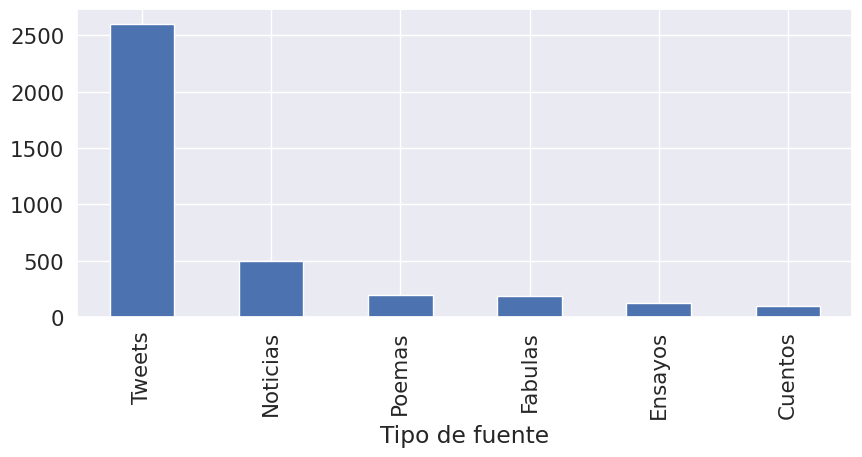

In [510]:
my_tags = list(data["Tipo de fuente"].unique())
plt.figure(figsize=(10,4))
data["Tipo de fuente"].value_counts().plot(kind='bar')

### Prerocesamiento de los datos

In [511]:
REEMPLAZAR_ESPACIO = re.compile('[/(){}\[\]\|@,;]')
SIMBOLOS_INCORRECTOS = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('spanish'))

def prerpocesamiento_tipo_text(texto):
    """
        text:  string
        
        return: strin modificado
    """
    #diccionario en donde se reemplazan algunos caracteres mal procesados
    diccionario_tildes= {
        "Ã¡": "á",
        "Ã©": "é",
        "Ã": "í",
        "Ã³": "ó",
        "Ãº": "ú",
        "Ã±": "ñ",
    }
    for mal_codificado, bien_codificado in diccionario_tildes.items():
        texto = texto.replace(mal_codificado, bien_codificado)

    texto = texto.lower() # se convierte todo el texto a su versión en munuscula
    texto=texto.replace('\xad', '')
    texto = REEMPLAZAR_ESPACIO.sub(' ', texto) # replace REPLACE_BY_SPACE_RE symbols by space in text
    texto = SIMBOLOS_INCORRECTOS.sub('', texto) # delete symbols which are in BAD_SYMBOLS_RE from text
    texto = ' '.join(word for word in texto.split() if word not in STOPWORDS) # delete stopwors from text
    return texto

In [512]:
data['texto_procesado'] = data['Texto'].apply(prerpocesamiento_tipo_text)

Se dividen los datos entre train y test

In [513]:
data['num_words']=data['texto_procesado'].apply(lambda x: len(x.split()))
data=data[data['num_words']>1]

In [514]:
data.sort_values('num_words')

,Texto,Tipo de fuente,Clasificacion,texto_procesado,num_words
1510,Al aire #LaTeleLetal,Tweets,Human,aire #lateleletal,2
1466,@josecaller @NoticiasRCN ðŸ™ŒðŸ�»ðŸ™ŒðŸ�»,Tweets,Human,josecaller noticiasrcn,2
1212,@colinita Jajaja,Tweets,Human,colinita jajaja,2
1499,Ya al aire @LaTele_Letal,Tweets,Human,aire latele_letal,2
1238,@infrahumano Nadie.,Tweets,Human,infrahumano nadie,2
...,...,...,...,...,...
479,"Y llegué a mi aposento. De la orgía, vibraba ...",Poemas,Human,llegu aposento orga vibraba an cerebro ardient...,1180
76,EL GRAN FRAUDE DEL CALENTAMIENTO GLOBAL Se ha ...,Ensayos,Human,gran fraude calentamiento global conferido gor...,1375
261,Es prácticamente imposible ver a Julio María S...,Noticias,Human,prcticamente imposible ver julio mara sanguine...,1715
263,"Cuando la marea del Pacífico subía, Pilar Quin...",Noticias,Human,marea pacfico suba pilar quintana cali 1972 te...,1905


In [515]:
X =data.texto_procesado
y = data["Tipo de fuente"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

Se inicia con el modelo de clasificar el tipo de fuente, primero se intenta con una maquina de soporte vectorial lineal 

In [516]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [517]:
%%time
from sklearn.metrics import classification_report

y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))


accuracy 0.9648648648648649
              precision    recall  f1-score   support

     Cuentos       1.00      0.68      0.81        38
     Ensayos       1.00      0.97      0.99        35
     Fabulas       0.94      0.77      0.84        60
    Noticias       0.95      0.99      0.97       144
      Poemas       0.93      0.85      0.89        67
      Tweets       0.97      1.00      0.98       766

    accuracy                           0.96      1110
   macro avg       0.96      0.88      0.91      1110
weighted avg       0.96      0.96      0.96      1110

CPU times: user 169 ms, sys: 66.4 ms, total: 235 ms
Wall time: 170 ms


Resultados:

-as

Ahora intentamos con bag of words con keras

In [518]:


max_words=6000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(X_train) # only fit on train
x_train = tokenize.texts_to_matrix(X_train)
x_test = tokenize.texts_to_matrix(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [519]:
# Construimos el modelo
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [520]:
model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=5,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/5
73/73 [==============================] - 5s 59ms/step - loss: 0.6625 - accuracy: 0.8677 - val_loss: 0.1349 - val_accuracy: 0.9653
Epoch 2/5
73/73 [==============================] - 4s 53ms/step - loss: 0.0443 - accuracy: 0.9979 - val_loss: 0.1006 - val_accuracy: 0.9730
Epoch 3/5
73/73 [==============================] - 4s 53ms/step - loss: 0.0146 - accuracy: 0.9991 - val_loss: 0.1116 - val_accuracy: 0.9691
Epoch 4/5
73/73 [==============================] - 4s 53ms/step - loss: 0.0075 - accuracy: 0.9991 - val_loss: 0.1225 - val_accuracy: 0.9730
Epoch 5/5
73/73 [==============================] - 4s 48ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.1276 - val_accuracy: 0.9730


In [521]:
score = model.evaluate(x_test, y_test,
                       batch_size=32, verbose=1)
print('Test accuracy:', score[1])

35/35 [==============================] - 0s 7ms/step - loss: 0.0727 - accuracy: 0.9829
Test accuracy: 0.9828828573226929


In [522]:
def prueba_modelo_tipo(texto):
    texto_limpio=pd.Series([prerpocesamiento_tipo_text(texto)])
    tokenizado=tokenize.texts_to_matrix(texto_limpio)
    prediccion=model.predict(tokenizado)
    predict_tipo=encoder.inverse_transform([prediccion[0].argmax()])
    return predict_tipo[0]


In [523]:
texto_ejemplo_poema="En la penumbra de la noche sosegada, donde las estrellas sus secretos revelan, mi mente vuela en alas de la nada, donde los sueños como luciérnagas destellan.Bajo el manto plateado de la luna, se tejen historias en el silencio, donde el corazón, como una fortuna, se llena de anhelos en este trance eterno.Susurros de hojas danzan con el viento, mientras la noche abraza el suspenso, y en el lienzo del cielo, un firmamento, pintado con los sueños que llevo dentro.Allí, donde los recuerdos se entrelazan, y las sombras danzan con la melodía, se despiertan los sueños que abrazan, la esperanza en esta mágica poesía.Que las estrellas guarden mis secretos, y la luna cuente mis anhelos, en este rincón de sueños discretos, donde la noche se convierte en cielo."

In [524]:
prueba_modelo_tipo(texto_ejemplo_poema)

1/1 [==============================] - 0s 69ms/step


'Poemas'

In [525]:
data["Tipo de fuente"].unique()

array(['Cuentos', 'Ensayos', 'Fabulas', 'Noticias', 'Poemas', 'Tweets'],
      dtype=object)

In [526]:
data_=data.copy()
data_=data_[data_["Tipo de fuente"]=="Tweets"]
X=data_["texto_procesado"]
y_clasificacion = data_["Clasificacion"].replace(["Human","LLM"],[0,1])
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X, y_clasificacion, test_size=0.3, random_state = 42)

In [527]:
y_train_cl

1567    0
3791    1
577     0
712     0
2778    1
       ..
2765    1
1666    0
1701    0
1866    0
1427    0
Name: Clasificacion, Length: 1815, dtype: int64

In [528]:
max_words=6000
tokenize_cl = text.Tokenizer(num_words=max_words, char_level=False)
tokenize_cl.fit_on_texts(X_train_cl) # only fit on train
x_train_cl = tokenize.texts_to_matrix(X_train_cl)
x_test_cl = tokenize.texts_to_matrix(X_test_cl)



num_classes = np.max(y_train_cl) + 1

In [529]:
num_classes

2

In [530]:
x_train_cl.shape[1]

6000

In [531]:
input_dim

6000

In [532]:
# Construimos el modelo
from keras import layers
input_dim = x_train_cl.shape[1]  # Number of features

model_cl = Sequential()
model_cl.add(layers.Dense(500, input_dim=input_dim, activation='relu'))
model_cl.add(layers.Dense(1, activation='sigmoid'))
model_cl.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model_cl.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 500)               3000500   
                                                                 
 dense_75 (Dense)            (None, 1)                 501       
                                                                 
Total params: 3001001 (11.45 MB)
Trainable params: 3001001 (11.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [533]:
y_train_cl = np.asarray(y_train_cl).astype('int').reshape((-1,1))
y_test_cl = np.asarray(y_test_cl).astype('int').reshape((-1,1))

In [534]:
y_train_cl

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [535]:
x_train_cl[0].shape[0]

6000

In [536]:
y_test_cl

array([[0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
    

In [537]:
history = model_cl.fit(x_train_cl, y_train_cl,
                    epochs=10,
                    verbose=True,
                    validation_data=(x_test_cl, y_test_cl),
                    batch_size=10)

Epoch 1/10
  6/182 [..............................] - ETA: 8s - loss: 0.6874 - accuracy: 0.6333

182/182 [==============================] - 9s 47ms/step - loss: 0.6128 - accuracy: 0.6623 - val_loss: 0.6154 - val_accuracy: 0.6465
Epoch 2/10
182/182 [==============================] - 8s 44ms/step - loss: 0.3552 - accuracy: 0.8479 - val_loss: 0.6773 - val_accuracy: 0.6362
Epoch 3/10
182/182 [==============================] - 8s 46ms/step - loss: 0.1750 - accuracy: 0.9355 - val_loss: 0.8350 - val_accuracy: 0.6247
Epoch 4/10
182/182 [==============================] - 8s 42ms/step - loss: 0.0981 - accuracy: 0.9664 - val_loss: 0.9911 - val_accuracy: 0.6414
Epoch 5/10
182/182 [==============================] - 8s 42ms/step - loss: 0.0674 - accuracy: 0.9802 - val_loss: 1.0918 - val_accuracy: 0.6452
Epoch 6/10
182/182 [==============================] - 8s 43ms/step - loss: 0.0553 - accuracy: 0.9824 - val_loss: 1.1994 - val_accuracy: 0.6350
Epoch 7/10
182/182 [==============================] - 8s 44ms/step - loss: 0.0465 - accuracy: 0.9818 - val_loss: 1.3095 - val_accuracy: 0.6337
Epoch 8/10

In [538]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

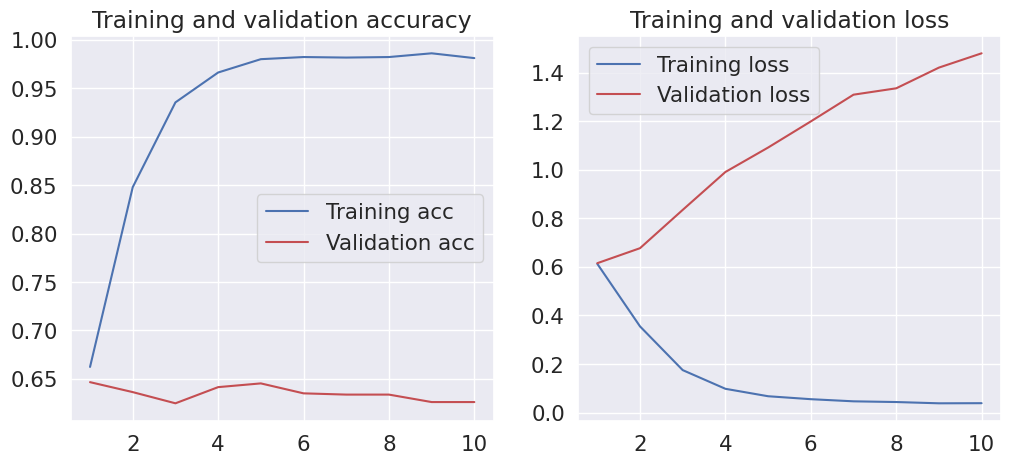

In [539]:
plot_history(history)

In [540]:
score = model_cl.evaluate(x_test_cl, y_test_cl,
                       batch_size=32, verbose=1)
print('Test accuracy:', score[1])

25/25 [==============================] - 0s 8ms/step - loss: 1.4800 - accuracy: 0.6260
Test accuracy: 0.6259639859199524


In [541]:
def prueba_modelo_clase(texto):
    texto_limpio=pd.Series([prerpocesamiento_tipo_text(texto)])
    tokenizado=tokenize_cl.texts_to_matrix(texto_limpio)
    prediccion=model_cl.predict(tokenizado)
    predict_tipo=prediccion[0]
    return predict_tipo[0]


In [542]:
texto_ejemplo_poema="soy un humano"

In [543]:
prueba_modelo_clase(texto_ejemplo_poema)

1/1 [==============================] - 0s 79ms/step


0.27289945

In [544]:
# Se corrigen algunos caracteres existentes en los textos, como lo son errores en lectura de tíldes y simbolos caracteristicos usados en tweets
def prerpocesamiento(texto):
    diccionario_tildes= {
        "Ã¡": "á",
        "Ã©": "é",
        "Ã": "í",
        "Ã³": "ó",
        "Ãº": "ú",
        "Ã±": "ñ",
    }
    for mal_codificado, bien_codificado in diccionario_tildes.items():
        texto = texto.replace(mal_codificado, bien_codificado)

    #preprocesamiento para los tweets
    # remover el símbolo de retweet "rt"
    texto = re.sub(r'^RT[\s]+', '', texto)
    # remover los liks
    texto = re.sub(r'https?://[^\s\n\r]+', '', texto)

    # remover hashtags
    # osolo se remueven los # de las palabras
    texto = re.sub(r'#', '', texto)
    texto=texto.lower()


    return texto

data.drop_duplicates(inplace=True)
#Corrección de caracteres existentes en los textos
data["Texto"]=data["Texto"].str.replace('\xad', '')
#Correccipón de tíldes
data["Texto"]=data["Texto"].apply(prerpocesamiento)



In [545]:
data['type']= data["Clasificacion"].replace(["LLM","Human"],[1,0])

In [546]:
data["Tipo de fuente"].unique()

array(['Cuentos', 'Ensayos', 'Fabulas', 'Noticias', 'Poemas', 'Tweets'],
      dtype=object)

In [547]:
from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')


In [548]:
import re

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()




corpus = []


text = list(data['Texto'])

for i in range(len(text)):

    r = re.sub('[^a-zA-Z]', ' ', text[i])

    r = r.lower()

    r = r.split()

    r = [word for word in r if word not in stopwords.words('spanish')]

    r = [spanish_stemmer.stem(word) for word in r]

    r = ' '.join(r)

    corpus.append(r)

data['text'] = corpus

[nltk_data] Downloading package wordnet to /home/sergio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [549]:
data

,Texto,Tipo de fuente,Clasificacion,texto_procesado,num_words,type,text
0,el rey de los animales se reunieron los animal...,Cuentos,Human,rey animales reunieron animales monte elegir r...,370,0,rey animal reun animal mont eleg rey hac d as ...
1,domingo 7 había una vez dos compadres jorobado...,Cuentos,Human,domingo 7 haba vez dos compadres jorobados ric...,558,0,doming hab vez dos compadr jorob ric pobr ric ...
2,francisco el hombre en los albores del siglo x...,Cuentos,Human,francisco hombre albores siglo xx dos comercia...,593,0,francisc hombr albor sigl xx dos comerci orig ...
3,aminta peláez- la leyenda de wareke hace muchí...,Cuentos,Human,aminta pelez leyenda wareke hace muchsimos aos...,429,0,amint pel ez leyend warek hac much sim inici p...
4,el oasis de belissama atlaua paseaba con belis...,Cuentos,Human,oasis belissama atlaua paseaba belissama ancia...,90,0,oasis belissam atlau pas belissam ancian cabal...
...,...,...,...,...,...,...,...
3833,la educación cívica es fundamental para la con...,Tweets,LLM,educacin cvica fundamental construccin socieda...,12,1,educaci n c vic fundamental construcci n socie...
3839,la corrupción es una amenaza para la democraci...,Tweets,LLM,corrupcin amenaza democracia desarrollo pas to...,12,1,corrupci n amenaz democraci desarroll pa s tom...
3841,el sistema político necesita una reforma profu...,Tweets,LLM,sistema poltico necesita reforma profunda gara...,15,1,sistem pol tic necesit reform profund garantic...
3844,la violencia y la delincuencia son una amenaza...,Tweets,LLM,violencia delincuencia amenaza seguridad ciuda...,14,1,violenci delincuent amenaz segur ciudadan bien...


In [550]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data["text"],
                                                    data["type"],
                                                    test_size=0.33,
                                                    random_state=42)

In [551]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

vectorizer= CountVectorizer(ngram_range=(1,2)).fit(X_train)
X_train_vectorized =vectorizer.transform(X_train)
X_train_vectorized.toarray().shape

model=MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized,y_train)

predictions= model.predict(vectorizer.transform(X_test))

In [552]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

<Axes: >

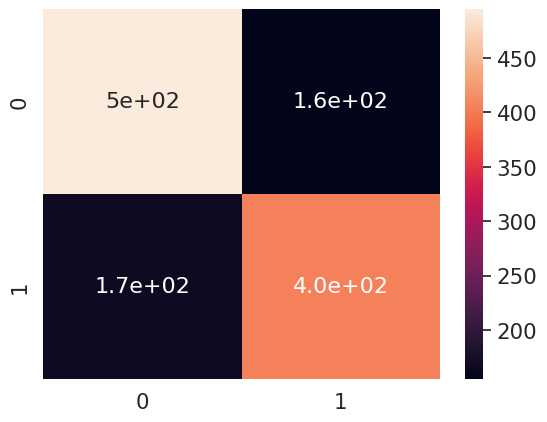

In [553]:
from sklearn import metrics
array = metrics.confusion_matrix(y_test, predictions)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df_cm = pd.DataFrame(array)

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

In [554]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print("the accuracy from Nave Bayes model is "+ str(accuracy_score(y_test, predictions)))
print("the recall from Nave Bayes model is "+ str(recall_score(y_test, predictions)))

the accuracy from Nave Bayes model is 0.7371007371007371
the recall from Nave Bayes model is 0.7092819614711033


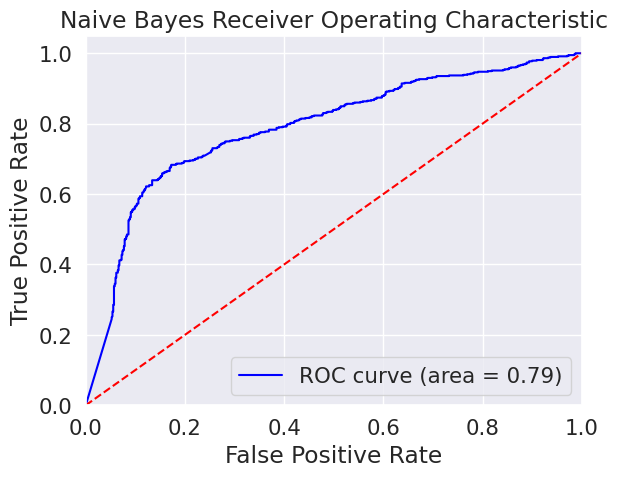

In [555]:
from sklearn.metrics import roc_curve,auc

y_pred_proba=model.predict_proba(vectorizer.transform(X_test))[:, 1]

fpr,tpr,thresholds=roc_curve(y_test,y_pred_proba)
roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle= '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [556]:
from sklearn.svm import SVC
model_svm=SVC(C=1.0,kernel="linear",probability=True)
model_svm.fit(X_train_vectorized,y_train)
y_pred_svm=model_svm.predict(vectorizer.transform(X_test))


<Axes: >

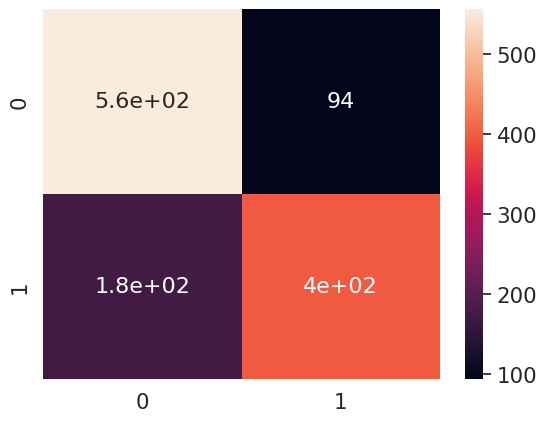

In [557]:
array = metrics.confusion_matrix(y_test, y_pred_svm)
df_cm = pd.DataFrame(array)

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

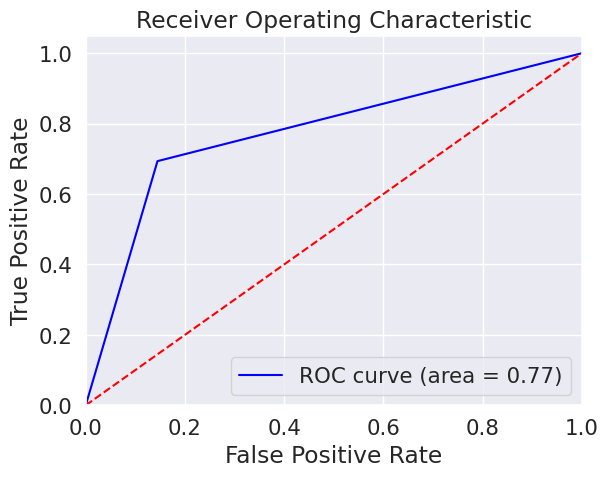

In [558]:
from sklearn.metrics import roc_curve,auc

y_pred_proba=model_svm.predict_proba(vectorizer.transform(X_test))[:, 1]

fpr,tpr,thresholds=roc_curve(y_test,y_pred_svm)
roc_auc=auc(fpr,tpr)

roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle= '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [559]:
print("the accuracy from Nave Bayes model is "+str(accuracy_score(y_test, y_pred_svm)))
print("the recall from Nave Bayes model is "+ str(recall_score(y_test, y_pred_svm)))

the accuracy from Nave Bayes model is 0.7796887796887797
the recall from Nave Bayes model is 0.6935201401050788


In [560]:
stop_words = set(stopwords.words('spanish'))

In [561]:
def numero_stop_words(texto):
    texto=word_tokenize(texto)
    stopwords_x = [w for w in texto if w in stop_words]
    num_stopw=len(stopwords_x)
    return num_stopw

def numero_palabras_unicas(texto):
    texto=word_tokenize(texto)
    unicos = len([*set(texto)])
    return unicos

def numero_puntuacion(texto):
    texto=word_tokenize(texto)
    puntuacion = [w for w in texto if w in string.punctuation]
    num_puntuacion=len(puntuacion)
    return num_puntuacion


In [562]:
data["numero_palabras"]=data["Texto"].apply(lambda x: len(word_tokenize(x)))
data["numero_stopwords"]=data["Texto"].apply(numero_stop_words)
data["numero_palabras_unicas"]=data["Texto"].apply(numero_palabras_unicas)
data["numero_puntuacion"]=data["Texto"].apply(numero_puntuacion)
data=data[data["numero_palabras"]!=0]

In [563]:
data[data["numero_palabras"]==0]

,Texto,Tipo de fuente,Clasificacion,texto_procesado,num_words,type,text,numero_palabras,numero_stopwords,numero_palabras_unicas,numero_puntuacion


In [564]:
data["stop_words/texto"]=data["numero_stopwords"]/data["numero_palabras"]
data["numero_palabras_unicas/texto"]=data["numero_palabras_unicas"]/data["numero_palabras"]
data["numero_puntuacion/texto"]=data["numero_puntuacion"]/data["numero_palabras"]

/tmp/ipykernel_4272/3982630834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["stop_words/texto"]=data["numero_stopwords"]/data["numero_palabras"]
/tmp/ipykernel_4272/3982630834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["numero_palabras_unicas/texto"]=data["numero_palabras_unicas"]/data["numero_palabras"]
/tmp/ipykernel_4272/3982630834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

/tmp/ipykernel_4272/3734433403.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['type']= data["Clasificacion"].replace(["LLM","Human"],[1,0])


(array([0.93430657, 2.19202695, 6.75575519, 6.88152723, 5.08478383,
        3.21617069, 2.10218978, 1.27568782, 1.40145985, 0.46715328,
        0.53902302, 0.12577204, 0.44918585, 0.07186974, 0.0539023 ,
        0.        , 0.37731611, 0.01796743, 0.        , 0.0539023 ]),
 array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
        0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
        0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ]),
 <BarContainer object of 20 artists>)

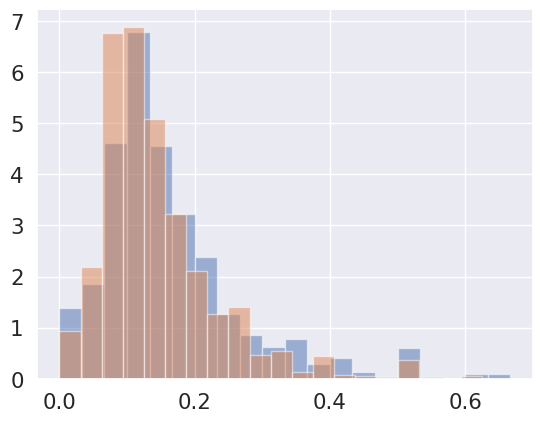

In [565]:
data['type']= data["Clasificacion"].replace(["LLM","Human"],[1,0])


plt.hist(data[(data["type"]==0)]["numero_puntuacion/texto"], bins=20, density=True, alpha=0.5, label='0')
plt.hist(data[(data["type"]==1)]["numero_puntuacion/texto"], bins=20, density=True, alpha=0.5, label='1')




([<matplotlib.axis.XTick at 0x7f0f20ca0ee0>,
 [Text(1, 0, 'Human'), Text(2, 0, 'LLM')])

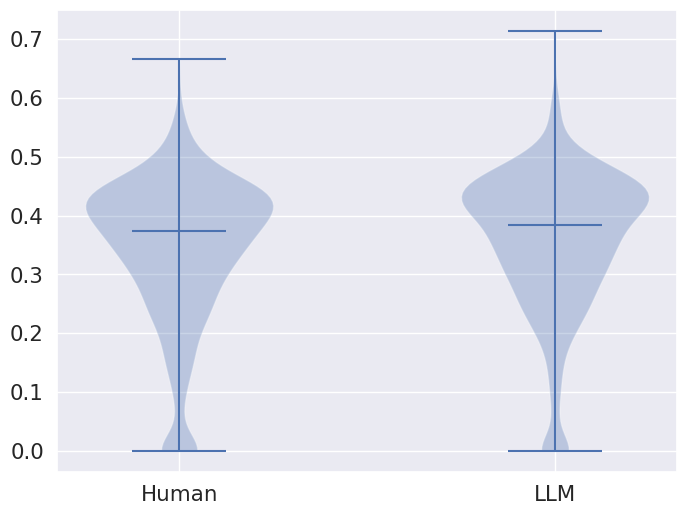

In [566]:
plt.figure(figsize=(8, 6))
plt.violinplot([data[(data["type"]==0)]["stop_words/texto"], data[(data["type"]==1)]["stop_words/texto"]], showmedians=True)
plt.xticks([1, 2], ['Human', 'LLM'])

In [567]:
data.sort_values("numero_palabras")

,Texto,Tipo de fuente,Clasificacion,texto_procesado,num_words,type,text,numero_palabras,numero_stopwords,numero_palabras_unicas,numero_puntuacion,stop_words/texto,numero_palabras_unicas/texto,numero_puntuacion/texto
3346,gratitud,Tweets,LLM,#gratitud https tco zjwlyxqutp,4,1,gratitud,1,0,1,0,0.000000,1.000000,0.000000
618,vanessanocumplircuarentenaes,Tweets,Human,#vanessanocumplircuarentenaes https tco ujrwmy...,4,0,vanessanocumplircuarenten,1,0,1,0,0.000000,1.000000,0.000000
3525,carpetassecretas,Tweets,LLM,#carpetassecretas https tco rzhaeb02tb,4,1,carpetassecret,1,0,1,0,0.000000,1.000000,0.000000
3529,alabrava,Tweets,LLM,#alabrava https tco lssp8b4b1z,4,1,alabrav,1,0,1,0,0.000000,1.000000,0.000000
3533,eldramadetodos,Tweets,LLM,#eldramadetodos https tco hoijgfwwyb,4,1,eldramadetod,1,0,1,0,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,"y llegué a mi aposento. de la orgía, vibraba ...",Poemas,Human,llegu aposento orga vibraba an cerebro ardient...,1180,0,llegu aposent org vibr n cerebr ardient estrue...,2695,1022,1027,444,0.379221,0.381076,0.164750
76,el gran fraude del calentamiento global se ha ...,Ensayos,Human,gran fraude calentamiento global conferido gor...,1375,0,gran fraud calent global confer gor onu premi ...,3038,1401,979,284,0.461159,0.322251,0.093483
261,es prácticamente imposible ver a julio maría s...,Noticias,Human,prcticamente imposible ver julio mara sanguine...,1715,0,pr ctic impos ver juli mar sanguinetti vest ma...,3805,1683,1215,418,0.442313,0.319317,0.109855
263,"cuando la marea del pacífico subía, pilar quin...",Noticias,Human,marea pacfico suba pilar quintana cali 1972 te...,1905,0,mare pac fic sub pil quintan cali ten regres c...,4393,2089,1320,481,0.475529,0.300478,0.109492


In [568]:
data["Tipo de fuente"].unique()

array(['Cuentos', 'Ensayos', 'Fabulas', 'Noticias', 'Poemas', 'Tweets'],
      dtype=object)

In [569]:
#EDA
#Mayusculas
#Frequencia en palabras
#Puntuación



In [570]:
def procesar_texto(texto):
    tokens = word_tokenize(texto)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)

data['texto_procesado'] = data['Texto'].apply(procesar_texto)

/tmp/ipykernel_4272/1414715398.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['texto_procesado'] = data['Texto'].apply(procesar_texto)


/tmp/ipykernel_4272/445627360.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['conteo_palabras_mayusculas'] = data['Texto'].apply(contar_palabras_mayusculas)
/tmp/ipykernel_4272/445627360.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['type']= data["Clasificacion"].replace(["LLM","Human"],[1,0])


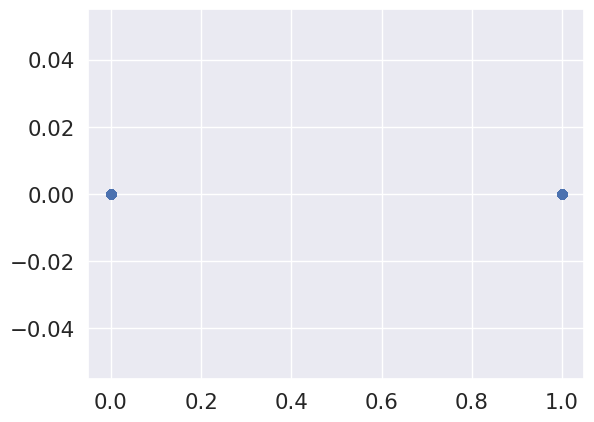

In [571]:
df_human=data[data["Clasificacion"]=="Human"]
df_llm=data[data["Clasificacion"]=="LLM"]



def contar_palabras_mayusculas(texto):
    palabras_con_mayusculas = [palabra for palabra in texto.split() if any(letra.isupper() for letra in palabra)]
    return len(palabras_con_mayusculas)

data['conteo_palabras_mayusculas'] = data['Texto'].apply(contar_palabras_mayusculas)
data['type']= data["Clasificacion"].replace(["LLM","Human"],[1,0])


plt.scatter(data['type'],data['conteo_palabras_mayusculas'] )


In [572]:
data



,Texto,Tipo de fuente,Clasificacion,texto_procesado,num_words,type,text,numero_palabras,numero_stopwords,numero_palabras_unicas,numero_puntuacion,stop_words/texto,numero_palabras_unicas/texto,numero_puntuacion/texto,conteo_palabras_mayusculas
0,el rey de los animales se reunieron los animal...,Cuentos,Human,rey animales reunieron animales monte elegir r...,370,0,rey animal reun animal mont eleg rey hac d as ...,852,350,302,136,0.410798,0.354460,0.159624,0
1,domingo 7 había una vez dos compadres jorobado...,Cuentos,Human,domingo vez dos compadres jorobados rico pobre...,558,0,doming hab vez dos compadr jorob ric pobr ric ...,1204,537,446,119,0.446013,0.370432,0.098837,0
2,francisco el hombre en los albores del siglo x...,Cuentos,Human,francisco hombre albores siglo xx dos comercia...,593,0,francisc hombr albor sigl xx dos comerci orig ...,1261,525,537,141,0.416336,0.425852,0.111816,0
3,aminta peláez- la leyenda de wareke hace muchí...,Cuentos,Human,aminta leyenda wareke hace muchísimos años ini...,429,0,amint pel ez leyend warek hac much sim inici p...,996,471,323,127,0.472892,0.324297,0.127510,0
4,el oasis de belissama atlaua paseaba con belis...,Cuentos,Human,oasis belissama atlaua paseaba belissama ancia...,90,0,oasis belissam atlau pas belissam ancian cabal...,191,83,116,17,0.434555,0.607330,0.089005,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,la educación cívica es fundamental para la con...,Tweets,LLM,educación cívica fundamental construcción soci...,12,1,educaci n c vic fundamental construcci n socie...,24,11,19,2,0.458333,0.791667,0.083333,0
3839,la corrupción es una amenaza para la democraci...,Tweets,LLM,corrupción amenaza democracia desarrollo país ...,12,1,corrupci n amenaz democraci desarroll pa s tom...,26,12,22,2,0.461538,0.846154,0.076923,0
3841,el sistema político necesita una reforma profu...,Tweets,LLM,sistema político necesita reforma profunda gar...,15,1,sistem pol tic necesit reform profund garantic...,29,12,23,2,0.413793,0.793103,0.068966,0
3844,la violencia y la delincuencia son una amenaza...,Tweets,LLM,violencia delincuencia amenaza seguridad ciuda...,14,1,violenci delincuent amenaz segur ciudadan bien...,32,16,24,2,0.500000,0.750000,0.062500,0


In [573]:
import string
def contar_signos_puntuacion(texto):
    cantidad_signos = len([c for c in texto.split() if c in string.punctuation])

    return cantidad_signos

data['conteo_signos_puntuacion'] = data['Texto'].apply(contar_signos_puntuacion)



/tmp/ipykernel_4272/2718916367.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['conteo_signos_puntuacion'] = data['Texto'].apply(contar_signos_puntuacion)


In [574]:
puntuacion_human=data[data["Clasificacion"]=="Human"]['conteo_signos_puntuacion'].sum()
puntuacion_llm=data[data["Clasificacion"]=="LLM"]['conteo_signos_puntuacion'].sum()

print(puntuacion_human)
print(puntuacion_llm)

359
481


In [575]:
data

,Texto,Tipo de fuente,Clasificacion,texto_procesado,num_words,type,text,numero_palabras,numero_stopwords,numero_palabras_unicas,numero_puntuacion,stop_words/texto,numero_palabras_unicas/texto,numero_puntuacion/texto,conteo_palabras_mayusculas,conteo_signos_puntuacion
0,el rey de los animales se reunieron los animal...,Cuentos,Human,rey animales reunieron animales monte elegir r...,370,0,rey animal reun animal mont eleg rey hac d as ...,852,350,302,136,0.410798,0.354460,0.159624,0,0
1,domingo 7 había una vez dos compadres jorobado...,Cuentos,Human,domingo vez dos compadres jorobados rico pobre...,558,0,doming hab vez dos compadr jorob ric pobr ric ...,1204,537,446,119,0.446013,0.370432,0.098837,0,0
2,francisco el hombre en los albores del siglo x...,Cuentos,Human,francisco hombre albores siglo xx dos comercia...,593,0,francisc hombr albor sigl xx dos comerci orig ...,1261,525,537,141,0.416336,0.425852,0.111816,0,0
3,aminta peláez- la leyenda de wareke hace muchí...,Cuentos,Human,aminta leyenda wareke hace muchísimos años ini...,429,0,amint pel ez leyend warek hac much sim inici p...,996,471,323,127,0.472892,0.324297,0.127510,0,0
4,el oasis de belissama atlaua paseaba con belis...,Cuentos,Human,oasis belissama atlaua paseaba belissama ancia...,90,0,oasis belissam atlau pas belissam ancian cabal...,191,83,116,17,0.434555,0.607330,0.089005,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,la educación cívica es fundamental para la con...,Tweets,LLM,educación cívica fundamental construcción soci...,12,1,educaci n c vic fundamental construcci n socie...,24,11,19,2,0.458333,0.791667,0.083333,0,0
3839,la corrupción es una amenaza para la democraci...,Tweets,LLM,corrupción amenaza democracia desarrollo país ...,12,1,corrupci n amenaz democraci desarroll pa s tom...,26,12,22,2,0.461538,0.846154,0.076923,0,0
3841,el sistema político necesita una reforma profu...,Tweets,LLM,sistema político necesita reforma profunda gar...,15,1,sistem pol tic necesit reform profund garantic...,29,12,23,2,0.413793,0.793103,0.068966,0,0
3844,la violencia y la delincuencia son una amenaza...,Tweets,LLM,violencia delincuencia amenaza seguridad ciuda...,14,1,violenci delincuent amenaz segur ciudadan bien...,32,16,24,2,0.500000,0.750000,0.062500,0,0


In [576]:
df_human['conteo_palabras_mayusculas'].sum()

KeyError: 'conteo_palabras_mayusculas'

In [ ]:
most_cuerrent_words_human=pd.Series(' '.join(df_human['texto_procesado']).lower().split()).value_counts()[:100]
most_cuerrent_words_llm=pd.Series(' '.join(df_llm['texto_procesado']).lower().split()).value_counts()[:100]

In [ ]:
print(df_human.shape)
print(df_llm.shape)

(1934, 5)
(1914, 5)
